In [ ]:
#import required classes and packages
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   
import os
import cv2
import numpy as np
from keras.utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, AveragePooling2D
from keras.layers import Convolution2D
from keras.models import Sequential, load_model, Model
import pickle
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
import keras
from sklearn.model_selection import train_test_split
import requests
import numpy_encoder
import json
from keras.applications import VGG19
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#yolo confidence threshold to detect skin disorder
CONFIDENCE_THRESHOLD = 0.50
GREEN = (0, 255, 0)

In [ ]:
#define and load class labels found in dataset
path = "Dataset"
labels = []
X = []
Y = []
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name.strip())   
print("Skin Disease Class Labels : "+str(labels))

In [ ]:
#define function to get class label of given image
def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index

In [ ]:
#load dataset image and process them
if os.path.exists("model/X.txt.npy"):
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else: #if images not process then read and process image pixels
    for root, dirs, directory in os.walk(path):#connect to dataset folder
        for j in range(len(directory)):#loop all images from dataset folder
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#read images
                img = cv2.resize(img, (32, 32))#resize image
                X.append(img) #add image pixels to X array
                label = getLabel(name)#get image label id
                Y.append(label)#add image label                
    X = np.asarray(X)#convert array as numpy array
    Y = np.asarray(Y)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)#shuffle images
    X = X[indices]
    Y = Y[indices]
    np.save('model/X.txt',X)#save process images and labels
    np.save('model/Y.txt',Y)
print("Dataset images loaded")
print("Total images found in dataset : "+str(X.shape[0]))
print()

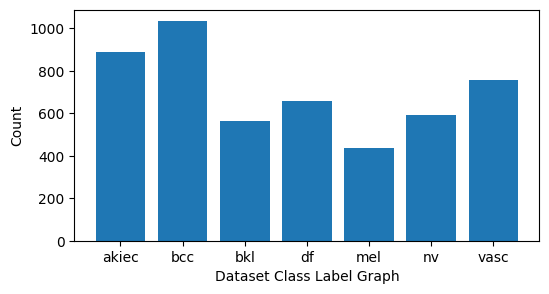

In [6]:
#visualizing class labels count found in dataset
names, count = np.unique(Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize = (6, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.show()

In [7]:
#preprocess images like normalization
X = X.astype('float32')
X = X/255 #normalized pixel values between 0 and 1
#divide dataset into two clients
client1_X = X
client1_Y = Y
client2_X = X[2501:X.shape[0]]
client2_Y = Y[2501:X.shape[0]]
client1_Y = to_categorical(client1_Y)
client2_Y = to_categorical(client2_Y)
#split both client dataset into train and test
client1_X_train, client1_X_test, client1_y_train, client1_y_test = train_test_split(client1_X, client1_Y, test_size=0.2)
client2_X_train, client2_X_test, client2_y_train, client2_y_test = train_test_split(client2_X, client2_Y, test_size=0.2) #split dataset into train and test
print("Client1 Training Size 80% = "+str(client1_X_train.shape[0]))
print("Client1 Testing Size 20%  = "+str(client1_X_test.shape[0]))
print("Client2 Training Size 80% = "+str(client2_X_train.shape[0]))
print("Client2 Testing Size 20%  = "+str(client2_X_test.shape[0]))

Client1 Training Size 80% = 3941
Client1 Testing Size 20%  = 986
Client2 Training Size 80% = 1940
Client2 Testing Size 20%  = 486


In [8]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [9]:
def calculateMetrics(algorithm, predict, y_test):
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  :  "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FScore    : "+str(f))    
    conf_matrix = confusion_matrix(y_test, predict) 
    plt.figure(figsize =(6, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.xticks(rotation=90)
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()    

31/31 [==============================] - 1s 16ms/step
CNN Client1 Local Accuracy  :  94.62474645030426
CNN Client1 Local Precision : 94.07282995650688
CNN Client1 Local Recall    : 93.96994527988046
CNN Client1 Local FScore    : 93.94279898807723


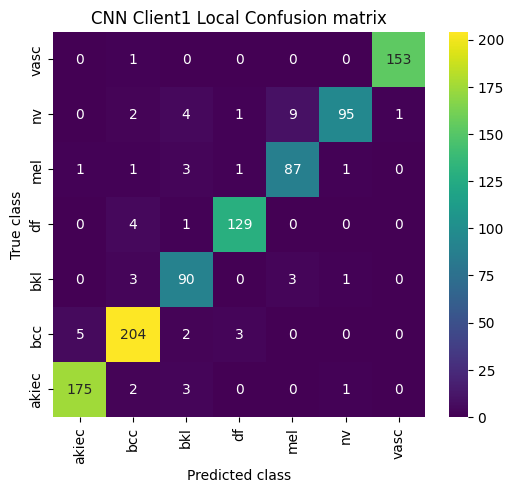

In [10]:
#training CNN model on client1 dataset
client1_cnn_model = Sequential()
client1_cnn_model.add(Convolution2D(32, (3 , 3), input_shape = (client1_X_train.shape[1], client1_X_train.shape[2], client1_X_train.shape[3]), activation = 'relu'))
client1_cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
client1_cnn_model.add(Convolution2D(32, (3, 3), activation = 'relu'))
client1_cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
client1_cnn_model.add(Flatten())
client1_cnn_model.add(Dense(units = 256, activation = 'relu'))
client1_cnn_model.add(Dense(units = client1_y_train.shape[1], activation = 'softmax'))
client1_cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/client1_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/client1_weights.hdf5', verbose = 1, save_best_only = True)
    hist = client1_cnn_model.fit(client1_X_train, client1_y_train, batch_size = 32, epochs = 30, validation_data=(client1_X_test, client1_y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/client1_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    client1_cnn_model.load_weights("model/client1_weights.hdf5")
#perform prediction on test data
predict = client1_cnn_model.predict(client1_X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(client1_y_test, axis=1)
#call this function to calculate accuracy
calculateMetrics("CNN Client1 Local", predict, y_test1)

In [11]:
#update client1 cnn local model to Federated server
client1_weight = client1_cnn_model.get_weights()#get weights of client1 model
local_weight_to_json = json.dumps(client1_weight, cls=numpy_encoder.NumpyEncoder)#convert weight to json
requests.put('http://127.0.0.1:8000/update', data=local_weight_to_json)#send weight to given URL federated server
print("Client1 weights send to Federated Server")

Client1 weights send to Federated Server


16/16 [==============================] - 0s 16ms/step
CNN Client2 Local Accuracy  :  87.65432098765432
CNN Client2 Local Precision : 88.67439537007124
CNN Client2 Local Recall    : 86.80986579748232
CNN Client2 Local FScore    : 87.29994143739381


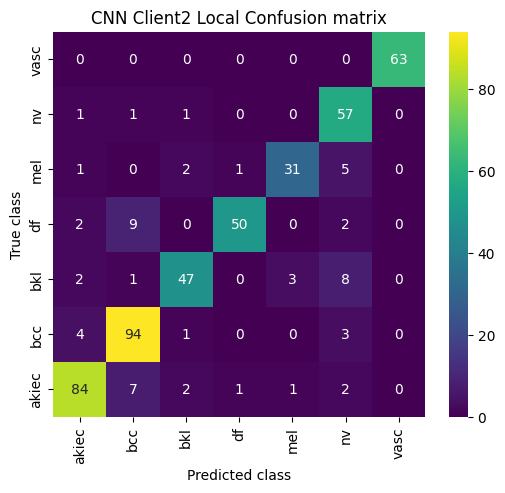

In [12]:
#train CNN model on Client2 dataset
client2_cnn_model = Sequential()
client2_cnn_model.add(Convolution2D(32, (3 , 3), input_shape = (client2_X_train.shape[1], client2_X_train.shape[2], client2_X_train.shape[3]), activation = 'relu'))
client2_cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
client2_cnn_model.add(Convolution2D(32, (3, 3), activation = 'relu'))
client2_cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
client2_cnn_model.add(Flatten())
client2_cnn_model.add(Dense(units = 256, activation = 'relu'))
client2_cnn_model.add(Dense(units = client2_y_train.shape[1], activation = 'softmax'))
client2_cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/client2_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/client2_weights.hdf5', verbose = 1, save_best_only = True)
    hist = client2_cnn_model.fit(client2_X_train, client2_y_train, batch_size = 32, epochs = 30, validation_data=(client2_X_test, client2_y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/client2_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    client2_cnn_model.load_weights("model/client2_weights.hdf5")
#perform prediction on test data   
predict = client2_cnn_model.predict(client2_X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(client2_y_test, axis=1)
#call this function to calculate accuracy
calculateMetrics("CNN Client2 Local", predict, y_test1)

In [13]:
#update client2 weights to federated server
client2_weights = client2_cnn_model.get_weights()#get weights of client1 model
local_weight_to_json = json.dumps(client2_weights, cls=numpy_encoder.NumpyEncoder)#convert weight to json
requests.put('http://127.0.0.1:8000/update', data=local_weight_to_json)#send weight to given URL federated server
print("Client2 weights send to Federated Server")

Client2 weights send to Federated Server


31/31 [==============================] - 1s 15ms/step
CNN Global Model Accuracy  :  93.91480730223124
CNN Global Model Precision : 93.85445268361258
CNN Global Model Recall    : 93.6157315005053
CNN Global Model FScore    : 93.62274307699491


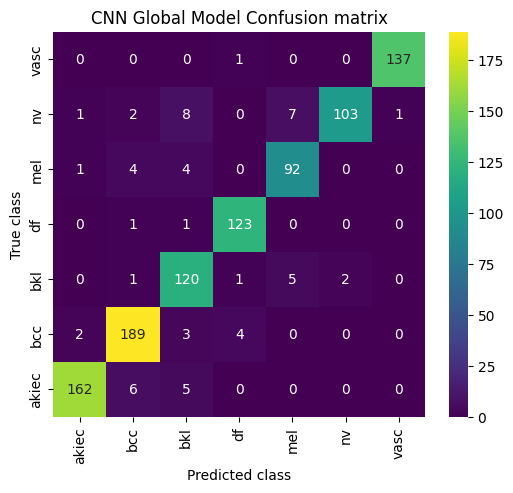

In [14]:
#now get weights from federated server to form global model
result = requests.get('http://127.0.0.1:8000/weight')#get weights from federated server
result_data = result.json()
global_weight = None
if result_data is not None:
    global_weight = []
    for i in range(len(result_data)):#loop all clients weights and append to global weight
        temp = np.array(result_data[i])
        global_weight.append(temp)
    global_weight = np.asarray(global_weight)
#split main data to train and test to perform prediction using global model
Y1 = to_categorical(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y1, test_size=0.2) #split dataset into train and test
#creating global model architecture
global_model = Sequential()
global_model.add(Convolution2D(32, (3 , 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
global_model.add(MaxPooling2D(pool_size = (2, 2)))
global_model.add(Convolution2D(32, (3, 3), activation = 'relu'))
global_model.add(MaxPooling2D(pool_size = (2, 2)))
global_model.add(Flatten())
global_model.add(Dense(units = 256, activation = 'relu'))
global_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
global_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#set global weight to global model
global_model.set_weights(global_weight)
#perform prediction on test data using global model weights
predict = global_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
#call this function to calculate accuracy
calculateMetrics("CNN Global Model", predict, y_test1)

31/31 [==============================] - 8s 228ms/step
VGG19 Accuracy  :  61.359026369168355
VGG19 Precision : 63.48811700536399
VGG19 Recall    : 60.608741016710276
VGG19 FScore    : 60.9701602432672


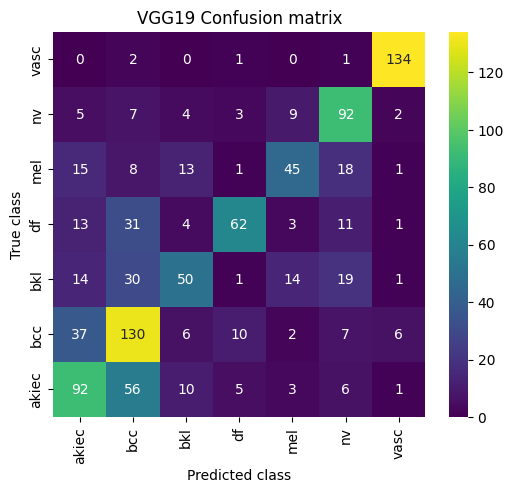

In [15]:
#train VGG19 algorithm
vgg = VGG19(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), include_top=False, weights='imagenet')
for layer in vgg.layers:
    layer.trainable = False
headModel = vgg.output
headModel = AveragePooling2D(pool_size=(1, 1))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(y_train.shape[1], activation="softmax")(headModel)
vgg_model = Model(inputs=vgg.input, outputs=headModel)
vgg_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/vgg_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/vgg_weights.hdf5', verbose = 1, save_best_only = True)
    hist = vgg_model.fit(X_train, y_train, batch_size = 32, epochs = 30, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/vgg_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    vgg_model.load_weights("model/vgg_weights.hdf5")
#perform prediction on test data using global model weights
predict = vgg_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
#call this function to calculate accuracy
calculateMetrics("VGG19", predict, y_test1)

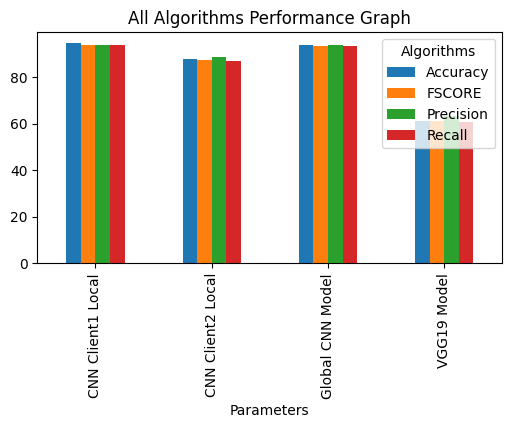

In [16]:
#plot all algorithm performance in tabukar format
import pandas as pd
df = pd.DataFrame([['CNN Client1 Local','Accuracy',accuracy[0]],['CNN Client1 Local','Precision',precision[0]],['CNN Client1 Local','Recall',recall[0]],['CNN Client1 Local','FSCORE',fscore[0]],
                   ['CNN Client2 Local','Accuracy',accuracy[1]],['CNN Client2 Local','Precision',precision[1]],['CNN Client2 Local','Recall',recall[1]],['CNN Client2 Local','FSCORE',fscore[1]],
                   ['Global CNN Model','Accuracy',accuracy[2]],['Global CNN Model','Precision',precision[2]],['Global CNN Model','Recall',recall[2]],['Global CNN Model','FSCORE',fscore[2]],
                   ['VGG19 Model','Accuracy',accuracy[3]],['VGG19 Model','Precision',precision[3]],['VGG19 Model','Recall',recall[3]],['VGG19 Model','FSCORE',fscore[3]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot(index="Parameters", columns="Algorithms", values="Value").plot(kind='bar', figsize=(6, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [17]:
#display all algorithm performnace
algorithms = ['CNN Client1 Local', 'CNN Client2 Local', 'CNN Global Weights', 'VGG19 Model']
data = []
for i in range(len(accuracy)):
    data.append([algorithms[i], accuracy[i], precision[i], recall[i], fscore[i]])
data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy', 'Precision', 'Recall', 'FSCORE'])
data  

,Algorithm Name,Accuracy,Precision,Recall,FSCORE
0,CNN Client1 Local,94.624746,94.072830,93.969945,93.942799
1,CNN Client2 Local,87.654321,88.674395,86.809866,87.299941
2,CNN Global Weights,93.914807,93.854453,93.615732,93.622743
3,VGG19 Model,61.359026,63.488117,60.608741,60.970160


In [18]:
#load Yolo Model
yolo_model = YOLO("model/best.pt")
print("Yolo Model Loaded")

Yolo Model Loaded


In [19]:
def detectDisorder(frame):
    global yolo_model
    detections = yolo_model(frame)[0]
    # loop over the detections
    for data in detections.boxes.data.tolist():
        # extract the confidence (i.e., probability) associated with the detection
        confidence = data[4]
        cls_id = data[5]
        # filter out weak detections by ensuring the 
        # confidence is greater than the minimum confidence
        if float(confidence) >= CONFIDENCE_THRESHOLD:
            xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
            cv2.rectangle(frame, (xmin, ymin) , (xmax, ymax), GREEN, 2)         
    return frame


In [20]:
#=================flask code starts here
from flask import Flask, render_template, request, redirect, url_for, session,send_from_directory
import base64
import io

In [21]:
app = Flask(__name__)
app.secret_key = 'welcome'

In [22]:
@app.route('/Predict', methods=['GET', 'POST'])
def predictView():
    return render_template('Predict.html', msg='')

@app.route('/index', methods=['GET', 'POST'])
def index():
    return render_template('index.html', msg='')

@app.route('/AdminLogin', methods=['GET', 'POST'])
def AdminLogin():
    return render_template('AdminLogin.html', msg='')

@app.route('/AdminLoginAction', methods=['GET', 'POST'])
def AdminLoginAction():
    if request.method == 'POST' and 't1' in request.form and 't2' in request.form:
        user = request.form['t1']
        password = request.form['t2']
        if user == "admin" and password == "admin":
            return render_template('AdminScreen.html', msg="Welcome "+user)
        else:
            return render_template('AdminLogin.html', msg="Invalid login details")

@app.route('/Logout')
def Logout():
    return render_template('index.html', msg='')

def getModel():
    global global_weight
    global_model = Sequential()
    global_model.add(Convolution2D(32, (3 , 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
    global_model.add(MaxPooling2D(pool_size = (2, 2)))
    global_model.add(Convolution2D(32, (3, 3), activation = 'relu'))
    global_model.add(MaxPooling2D(pool_size = (2, 2)))
    global_model.add(Flatten())
    global_model.add(Dense(units = 256, activation = 'relu'))
    global_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
    global_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    #set global weight to global model
    global_model.set_weights(global_weight)
    return global_model

@app.route('/PredictAction', methods=['GET', 'POST'])
def PredictAction():   
    if request.method == 'POST':
        file = request.files['t1']
        img_bytes = file.read()
        if os.path.exists("static/test.jpg"):
            os.remove("static/test.jpg")
        with open('static/test.jpg', mode="wb") as jpg:
            jpg.write(img_bytes)
        jpg.close()
        global_model = getModel()
        image = cv2.imread('static/test.jpg')#read test image
        img = cv2.resize(image, (32, 32))#resize image
        im2arr = np.array(img)
        im2arr = im2arr.reshape(1,32,32,3)#convert image as 4 dimension
        img = np.asarray(im2arr)
        img = img.astype('float32')#convert image features as float
        img = img/255 #normalized image
        predict = global_model.predict(img)#now predict dog breed
        predict = np.argmax(predict)
        img = cv2.imread("static/test.jpg")
        img = detectDisorder(img)
        img = cv2.resize(img, (500,300))#display image with predicted output
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.putText(img, 'Skin Disorder : '+labels[predict], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
        plt.imshow(img)
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight')
        plt.close()
        img_b64 = base64.b64encode(buf.getvalue()).decode() 
        return render_template('AdminScreen.html', msg='Skin Disorder : '+labels[predict], img = img_b64)

In [ ]:
if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
